In [5]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime as datetime

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
import pickle

from sklearn.preprocessing import MinMaxScaler

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2010_2015.nc')
ds

<xarray.Dataset> Size: 12GB
Dimensions:         (dt: 1479824, mlat: 40, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 12MB 2010-01-01 ... 2015-12-31T23:58:00
  * mlat            (mlat) float64 320B 50.2 51.22 52.24 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables: (12/13)
    jPar            (dt, mlat, mlt) float64 11GB ...
    BX_GSE          (dt) float64 12MB ...
    BY_GSE          (dt) float64 12MB ...
    BZ_GSE          (dt) float64 12MB ...
    flow_speed      (dt) int32 6MB ...
    proton_density  (dt) float64 12MB ...
    ...              ...
    AU_INDEX        (dt) float64 12MB ...
    SYM_H           (dt) float64 12MB ...
    ASY_H           (dt) float64 12MB ...
    F10.7           (dt) int32 6MB ...
    Kp              (dt) float64 12MB ...
    doy             (dt) int32 6MB ...

In [18]:
# Initialize scalers for the target variable and input variables
input_scaler = MinMaxScaler()

# Extract the target variable and reshape for scaling
target_var = ds['jPar'].values  # shape (t (n), mlat (50), mlt (24))

# Extract and scale input variables (variables that are dependent only on 'dt')
input_vars = ['BX_GSE', 'BY_GSE', 'BZ_GSE', 'flow_speed', 'proton_density', 'AL_INDEX', 'AU_INDEX', 'SYM_H', 'ASY_H', 'F10.7', 'Kp']
input_data = np.array([ds[var].values for var in input_vars]).T  # shape (22320, number_of_vars)
input_data_scaled = input_scaler.fit_transform(input_data)

file_path = f'scaler_id3.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(input_scaler, file)

def create_sequences(target_data, input_data, lookback=30):
    X, y = [], []
    for i in range(len(target_data) - lookback):
        X.append(input_data[i:i+lookback].T)
        y.append(target_data[i+lookback])

    return np.array(X), np.array(y)

lookback = 30
X, y = create_sequences(target_var, input_data_scaled, lookback=lookback)

X.shape, y.shape

((1479794, 11, 30), (1479794, 40, 24))

In [9]:
def simple_time_series_split(X, y, train_ratio=0.9, test_ratio=0.05):

    # Calculate split indices
    train_idx = int(len(X) * train_ratio)
    test_idx = int(len(X) * (train_ratio +test_ratio))

    # Perform the split
    X_train, X_val, X_test = X[:train_idx], X[train_idx:test_idx], X[test_idx:]
    y_train, y_val, y_test = y[:train_idx], y[train_idx:test_idx], y[test_idx:]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

#X_train, X_val, X_test, y_train, y_val, y_test = simple_time_series_split(X, y)
#X_train.shape, X_val.shape, X_test.shape

In [10]:
def random_time_series_split(X, y, train_ratio=0.8, val_ratio=0.1, segment_length=1440):
    total_segments = len(X) // segment_length
    #total_samples = total_segments * segment_length
    
    # Shuffle indices to randomly select segments
    indices = np.arange(total_segments)
    np.random.shuffle(indices)
    
    # Calculate sizes of train, validation, and test sets
    train_size = int(total_segments * train_ratio)
    val_size = int(total_segments * val_ratio)
    #test_size = total_segments - train_size - val_size
    
    # Select indices for train, validation, and test sets
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]
    
    # Function to extract segments
    def extract_segments(indices):
        X_segments = []
        y_segments = []
        for idx in indices:
            start_idx = idx * segment_length
            X_segment = X[start_idx:start_idx + segment_length]
            y_segment = y[start_idx:start_idx + segment_length]
            X_segments.append(X_segment)
            y_segments.append(y_segment)
        return np.concatenate(X_segments), np.concatenate(y_segments)
    
    # Extract train, validation, and test sets
    X_train, y_train = extract_segments(train_indices)
    X_val, y_val = extract_segments(val_indices)
    X_test, y_test = extract_segments(test_indices)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = random_time_series_split(X, y)
X_train.shape, X_val.shape, X_test.shape

((1182240, 11, 30), (146880, 11, 30), (149760, 11, 30))

In [11]:
# Convert data to PyTorch tensors and move to GPU
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True) 
        
        self.fc = nn.Linear(hidden_size, 40*24)

    def forward(self, x):
        batch_size = x.size(0) # Get the batch size
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device) # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :]) # Get the last output of the LSTM
        out = out.view(-1, 40, 24) # Reshape to (batch_size, mlat, mlt)
        return out
    
    def reset_states(self):
        # Reset the internal states of the LSTM layer
        self.lstm.reset_parameters()

# Instantiate the model with lookback size
model = LSTM(lookback, 64, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(30, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=960, bias=True)
)

In [13]:
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = StepLR(optimizer, step_size=8, gamma=0.6)

In [14]:
# Train the model
num_epochs = 20
train_losses = []
val_losses = []

#early stopping
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Forward pass
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        train_outputs = model(X_batch)
        loss = loss_function(train_outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            val_outputs = model(X_batch)
            val_loss += loss_function(val_outputs, y_batch).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    #Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter += 1
        #print(f'Counter is at {counter}')
        
        if counter == patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
            break
        else:
            continue

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss (MAE): {train_loss:.4f}, Val Loss (MAE): {val_loss:.4f}')

best_model = model
best_model.load_state_dict(torch.load('best_model.pt'))

Epoch [1/20], Loss (MAE): 0.0945, Val Loss (MAE): 0.0976
Epoch [2/20], Loss (MAE): 0.0926, Val Loss (MAE): 0.0967
Epoch [3/20], Loss (MAE): 0.0920, Val Loss (MAE): 0.0962
Epoch [4/20], Loss (MAE): 0.0917, Val Loss (MAE): 0.0959
Epoch [5/20], Loss (MAE): 0.0914, Val Loss (MAE): 0.0958
Epoch [6/20], Loss (MAE): 0.0910, Val Loss (MAE): 0.0951
Epoch [7/20], Loss (MAE): 0.0903, Val Loss (MAE): 0.0945
Epoch [8/20], Loss (MAE): 0.0900, Val Loss (MAE): 0.0943
Epoch [9/20], Loss (MAE): 0.0895, Val Loss (MAE): 0.0938
Epoch [10/20], Loss (MAE): 0.0894, Val Loss (MAE): 0.0937
Epoch [11/20], Loss (MAE): 0.0893, Val Loss (MAE): 0.0935
Epoch [12/20], Loss (MAE): 0.0892, Val Loss (MAE): 0.0935
Epoch [13/20], Loss (MAE): 0.0891, Val Loss (MAE): 0.0934
Epoch [14/20], Loss (MAE): 0.0891, Val Loss (MAE): 0.0933
Epoch [15/20], Loss (MAE): 0.0890, Val Loss (MAE): 0.0933
Epoch [16/20], Loss (MAE): 0.0890, Val Loss (MAE): 0.0932
Epoch [17/20], Loss (MAE): 0.0887, Val Loss (MAE): 0.0930
Epoch [18/20], Loss (MA

<All keys matched successfully>

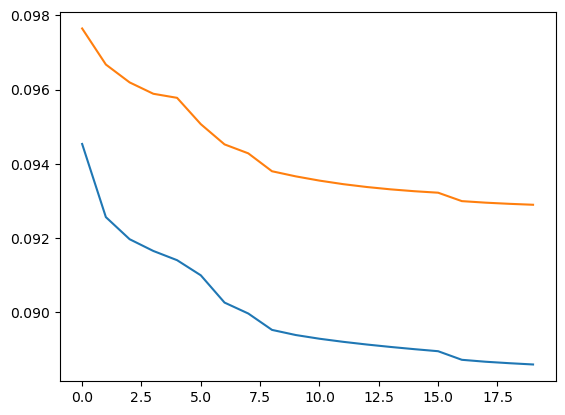

In [19]:
plt.plot(train_losses, label='Training Loss') 
plt.plot(val_losses, label='Validation Loss')

In [ ]:
#test
best_model.eval()

test_loss = 0.0
predictions = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        #batch_X = batch_X.permute(0, 2, 1)

        output = best_model(batch_X)
        loss = loss_function(output, batch_y)
        test_loss += loss.item()
        predictions.append(output)

predictions = torch.cat(predictions)
predictions = predictions.cpu().numpy()

avg_test_loss = test_loss / len(test_loader)
microamp = r'$\mu$A'
print(f'Test Loss: {np.sqrt(avg_test_loss):.3f} {microamp}')

mlat_idx = 39  #0 through 49
mlt_idx = 1 #0 through 23

#y_test = y_test.cpu().numpy()


In [ ]:
predictions_mean = np.mean(predictions, axis=(1, 2))
y_test_mean = np.mean(y_test, axis=(1, 2))

R = np.corrcoef(y_test_mean, predictions_mean)[0,1]
MAE = np.mean(np.abs(y_test_mean - predictions_mean))
RMSE = np.sqrt(np.mean((y_test_mean - predictions_mean)**2))
NRMSE = RMSE / (np.max(y_test_mean) - np.min(y_test_mean))

#R = np.corrcoef(y_test[:, mlat_idx, mlt_idx], predictions[:, mlat_idx, mlt_idx])[0,1]
#MAE = np.mean(np.abs(y_test[:, mlat_idx, mlt_idx] - predictions[:, mlat_idx, mlt_idx]))
#RMSE = np.sqrt(np.mean((y_test[:, mlat_idx, mlt_idx] - predictions[:, mlat_idx, mlt_idx])**2))
#NRMSE = RMSE / (np.max(y_test[:, mlat_idx, mlt_idx]) - np.min(y_test[:, mlat_idx, mlt_idx]))
print(f'R: {R:.3f}, RMSE: {RMSE:.3f}, NRMSE: {NRMSE:.3f}, MAE: {MAE:.3f}')


plt.figure(figsize=(10, 4))
plt.plot(y_test_mean, label='True')
plt.plot(predictions_mean, label='Predicted')
#plt.ylim(-1,1)
plt.legend()

In [ ]:
predictions_mean = np.mean(predictions, axis=0)
y_test_mean = np.mean(y_test, axis=0)
predictions_mean.shape, y_test_mean.shape

In [ ]:
fac = predictions_mean

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

#dt = open_amp['dt'].values
#start_time, end_time = dt_to_str(dt)

fac = fac.reshape(y_test_mean.shape[1], y_test_mean.shape[0]).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, y_test_mean.shape[1]) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(50, 90, y_test_mean.shape[0]) #convert to colat

#cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-0.5,.5 , 100))
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
#ax.set_title(f"{start_time} - {end_time}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-0.5, 0,  0.5], 
             orientation='horizontal')

plt.tight_layout()

In [ ]:
plt.contourf(fac, cmap=cmap, levels=np.linspace(-0.5, 0.5, 100))

In [115]:
def open_multiple_nc(nc_files):
    ds = xr.open_mfdataset(nc_files, concat_dim='dt', combine='nested', parallel=True)

    #ds = ds.sel(nRec=slice(16500, 17000))

    return ds

dir = '/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/excluded/*.nc'
open_multi_amp = open_multiple_nc(dir)
open_multi_amp

<xarray.Dataset> Size: 5MB
Dimensions:         (dt: 707, mlat: 40, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 6kB 2013-05-14 ... 2013-05-14T23:58:00
  * mlat            (mlat) float64 320B 50.2 51.22 52.24 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables: (12/13)
    jPar            (dt, mlat, mlt) float64 5MB dask.array<chunksize=(707, 40, 24), meta=np.ndarray>
    BX_GSE          (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    BY_GSE          (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    BZ_GSE          (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    flow_speed      (dt) int32 3kB dask.array<chunksize=(707,), meta=np.ndarray>
    proton_density  (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    ...              ...
    AU_INDEX        (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    SYM_H           (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    ASY_H           (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    F10.7           (dt) int32 3kB dask.array<chunksize=(707,), meta=np.ndarray>
    Kp              (dt) float64 6kB dask.array<chunksize=(707,), meta=np.ndarray>
    doy             (dt) int32 3kB dask.array<chunksize=(707,), meta=np.ndarray>

In [116]:
def split_to_df(ds):
    ds = ds.copy()

    dt = ds['dt'].values.flatten()
    BX_GSE = ds['BX_GSE'].values.flatten() #1
    BY_GSE = ds['BY_GSE'].values.flatten() #2
    BZ_GSE = ds['BZ_GSE'].values.flatten() #3
    flow_speed = ds['flow_speed'].values.flatten() #4
    proton_density = ds['proton_density'].values.flatten() #5
    AL_INDEX = ds['AL_INDEX'].values.flatten() #6
    AU_INDEX = ds['AU_INDEX'].values.flatten() #7
    SYM_H = ds['SYM_H'].values.flatten() #8
    ASY_H = ds['ASY_H'].values.flatten()  #9
    F10_7 = ds['F10.7'].values.flatten() #10
    Kp = ds['Kp'].values.flatten() #11

    #return BX_GSE.shape

    df_dict = {'dt':dt, 'BX_GSE': BX_GSE, 'BY_GSE': BY_GSE, 'BZ_GSE': BZ_GSE, 'flow_speed': flow_speed, 'proton_density': proton_density, 'AL_INDEX': AL_INDEX, 'AU_INDEX': AU_INDEX, 'SYM_H': SYM_H, 'ASY_H': ASY_H, 'F10.7': F10_7, 'Kp': Kp}
    df = pd.DataFrame(df_dict)
    
    df_2 = df.copy()
    df_2 = df_2.drop(columns=['dt'])

    return df, df_2

split_to_df(open_multi_amp)
df_raw, df_proc = split_to_df(open_multi_amp)
col_names = df_raw.columns

In [117]:
norm_arr = input_scaler.transform(df_proc)
norm_arr.shape

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


(707, 11)

In [118]:

def create_sequences(arr, lookback=30):
    X = []
    for i in range(len(arr) - lookback):
        X.append(arr[i:i+lookback].T)

    X = np.array(X)

    return X

proc_seq = create_sequences(norm_arr)
raw_seq = create_sequences(df_raw.values)

In [119]:
# Assuming best_model is already defined and loaded
device = torch.device('cpu')
best_model.to(device)  # Ensure the model is on the CPU
best_model.eval()

# Adjust the shape to match the model's expected input size
norm_proc = torch.tensor(proc_seq, dtype=torch.float32).to(device)
norm_proc = norm_proc.permute(0, 1, 2)  # Change from [848370, 11, 30] to [848370, 30, 11]

predictions = []

with torch.no_grad():
    for i in range(len(norm_proc)):
        output = best_model(norm_proc[i].unsqueeze(0))
        predictions.append(output)

predictions = torch.cat(predictions)
predictions = predictions.numpy()  # Tensor is already on CPU, no need to move again
predictions

array([[[ 0.00325462,  0.00137825,  0.00148021, ..., -0.06992307,
         -0.08501758, -0.09465727],
        [-0.09781235, -0.09407105, -0.06878592, ...,  0.00037204,
         -0.00067661,  0.00102685],
        [ 0.00064328,  0.00389401,  0.00099638, ..., -0.02132554,
         -0.06847613, -0.11169545],
        ...,
        [-0.00053896, -0.00470794, -0.0031586 , ..., -0.00361627,
          0.00074511,  0.00299062],
        [-0.00065417, -0.00484995, -0.00373982, ..., -0.01705481,
         -0.01029015,  0.00341815],
        [ 0.01055212,  0.0079544 ,  0.00099329, ..., -0.00024232,
         -0.0009541 , -0.00051565]],

       [[ 0.00323462,  0.00137676,  0.0014658 , ..., -0.06936079,
         -0.08429129, -0.09384288],
        [-0.09705313, -0.09334128, -0.06814293, ...,  0.00037152,
         -0.00064438,  0.0010385 ],
        [ 0.00064208,  0.00385188,  0.00099469, ..., -0.02134572,
         -0.06805141, -0.11074995],
        ...,
        [-0.00051016, -0.00470039, -0.00313881, ..., -

In [138]:
#remove first 30 from first dimension of open_multi_amp['jPar'].values
jPar = open_multi_amp['jPar'].values[30:]
jPar

array([[[-2.96181718e-02, -5.09717815e-02, -4.06089750e-02, ...,
         -3.18057273e-01, -2.79164763e-01, -1.74523723e-01],
        [-8.72252006e-02, -9.42977268e-03,  8.14256488e-02, ...,
         -1.68974040e-02, -4.80363940e-02, -2.66886045e-02],
        [ 2.73073724e-02,  4.60333464e-02, -6.49408787e-03, ...,
          1.62641503e-01, -7.73280423e-02, -1.63850631e-01],
        ...,
        [-6.52220710e-03, -1.11304234e-02,  1.70055917e-02, ...,
          3.22728597e-02, -7.53884771e-02, -1.35143920e-01],
        [-1.73573561e-01, -2.01773831e-01, -2.30436482e-01, ...,
          4.14190405e-03,  1.40629158e-02,  1.97631312e-02],
        [ 3.05181998e-02,  4.32295550e-02,  4.43782232e-02, ...,
          1.90906278e-02,  2.97009085e-02,  3.45167354e-02]],

       [[-5.35021906e-02, -1.03269614e-02,  1.38665042e-02, ...,
         -2.42834964e-01, -2.01157382e-01, -9.84065799e-02],
        [-5.55414891e-03,  7.28396212e-02,  1.41786983e-01, ...,
         -2.59012987e-02, -5.89986591e

In [176]:
ds = xr.Dataset({'Jpar_pred': (['dt', 'mlat', 'mlt'], predictions),
                 'Jpar_true': (['dt', 'mlat', 'mlt'], open_multi_amp['jPar'].values[30:])},
                coords = {'dt': df_raw['dt'].values[30:], 'mlat': np.arange(50, 90, 1), 'mlt': np.arange(0, 24, 1)})

#ds['Jpar_true'] = open_multi_amp['jPar'].values[30:]
#jPar = open_multi_amp['jPar'].values[30:]
ds

<xarray.Dataset> Size: 8MB
Dimensions:    (dt: 677, mlat: 40, mlt: 24)
Coordinates:
  * dt         (dt) datetime64[ns] 5kB 2013-05-14T01:00:00 ... 2013-05-14T23:...
  * mlat       (mlat) int64 320B 50 51 52 53 54 55 56 ... 83 84 85 86 87 88 89
  * mlt        (mlt) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    Jpar_pred  (dt, mlat, mlt) float32 3MB 0.003255 0.001378 ... -0.0004244
    Jpar_true  (dt, mlat, mlt) float64 5MB -0.02962 -0.05097 ... -0.05974

In [196]:
R = np.corrcoef(ds['Jpar_pred'].isel(dt=167).values, ds['Jpar_true'].isel(dt=167).values)[1,0]
RMSE = np.sqrt(np.mean((ds['Jpar_pred'].isel(dt=167).values - ds['Jpar_true'].isel(dt=167).values)**2))
MAE = np.mean(np.abs(ds['Jpar_pred'].isel(dt=167).values - ds['Jpar_true'].isel(dt=167).values))
NRMSE = RMSE / (np.max(ds['Jpar_true'].isel(dt=167).values) - np.min(ds['Jpar_true'].isel(dt=167).values))

print(f'R: {R:.3f}, RMSE: {RMSE:.3f}, NRMSE: {NRMSE:.3f}, MAE: {MAE:.3f}')

R: -0.012, RMSE: 0.131, NRMSE: 0.068, MAE: 0.082


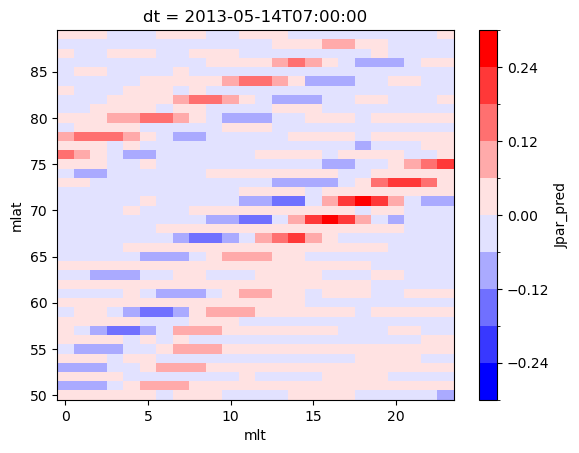

In [195]:
ds['Jpar_pred'].isel(dt=167).plot(levels=11, cmap='bwr')

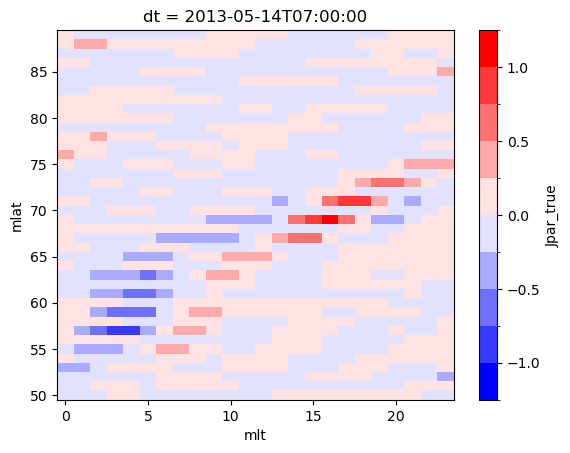

In [194]:
ds['Jpar_true'].isel(dt=167).plot(levels=11, cmap='bwr')